# Modeling DLPFC dataset using Neural Network 

这个教程将详细展示如何使用神经网络模型对小鼠大脑矢状面前部数据集(mouse brain sagittal anterior)建模，包含具体的调参过程。

## 目录
* [数据预处理](#数据预处理)
  1. [读取数据](#读取数据)
* [制作数据集](#制作数据集)
  1. [标签与特征](#标签与特征)
  2. [划分数据集](#划分数据集)
* [神经网络模型](#神经网络模型)
  1. [调参](#调参)
  2. [构建模型](#构建模型)

## 数据预处理

In [1]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np
import itertools
import pandas as pd

# 导入自己编写的库
from datapre import DataProcess as DP
from datapre import Sample as SP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 3
dirname = "human_DLPFC"

d:\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


设置默认的距离阈值为1.0

In [2]:
NEIGHBOR_DIS = 1.0

### 读取数据

标记线粒体基因，使用FeaturePlot函数可视化。

reading data\Human_DLPFC_151676\filtered_feature_bc_matrix.h5
 (0:00:00)


d:\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


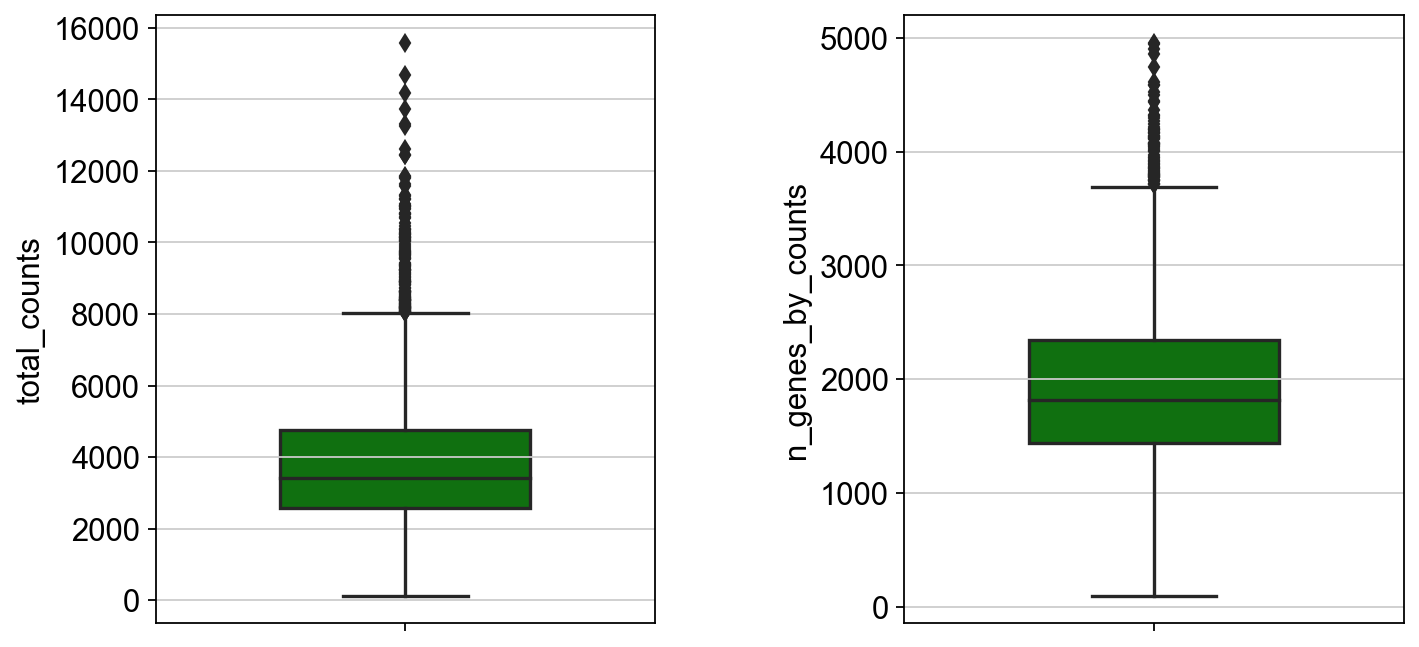

In [3]:
adata = sc.read_visium(path = "data/Human_DLPFC_151676/")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.FeaturePlot(adata)

导入空间转录组分群的reference，删除ground truth为缺失值的数据

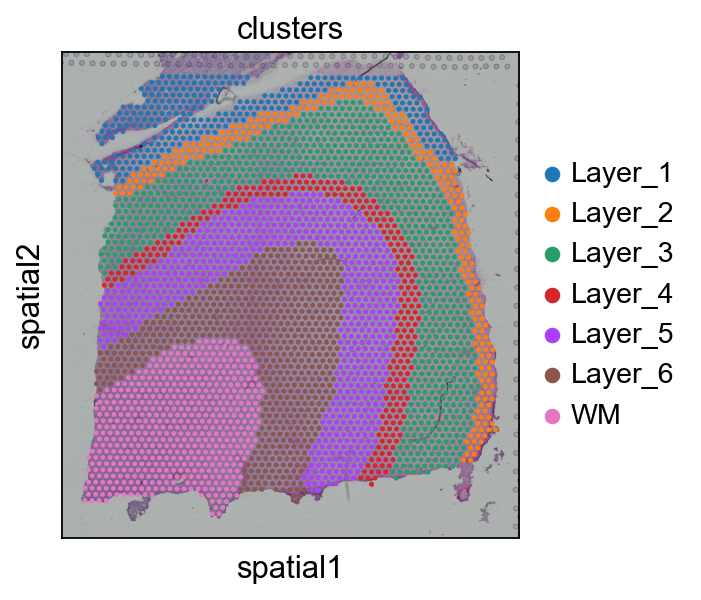

In [4]:
adata_ref = pd.read_csv("data/Human_DLPFC_151676/truth.txt", sep = '\t', header = None, index_col = 0)
adata_ref.columns = ['Ground Truth']
adata.obs['clusters'] = adata_ref.loc[adata.obs_names, 'Ground Truth']
adata = adata[~adata.obs["clusters"].isna(), ].copy()
sc.pl.spatial(adata, img_key = "hires", color = ["clusters"])

### 质量控制

过滤总表达量小于10的基因

In [5]:
sc.pp.filter_genes(adata, min_counts = 10)

filtered out 136 cells that have more than 8076 counts
filtered out 17634 genes that are detected in less than 10 cells


## 制作数据集

全局设置随机数种子

In [6]:
DP.setup_seed(0)

### 标签与特征

生成数据集标签

In [7]:
label_total, distance = DP.CreateLabel(adata, neighbor_dis = NEIGHBOR_DIS)

运行SpaGene，识别空间可变基因

In [8]:
DP.adata2seurat(adata, "Human_DLPFC_151676")
! Rscript spagene.R Human_DLPFC_151676 1000
spagene = DP.find_Spa("data/Human_DLPFC_151676/spagene.txt")

Loading required package: ggplot2
Loading required package: patchwork


进行归一化、对数化、标准化

In [9]:
adata = DP.data_final(adata, spagene = spagene)
count = adata.to_df().values

normalizing counts per cell
    finished (0:00:00)


C:\Users\我只是来搞笑的\AppData\Roaming\Python\Python39\site-packages\scanpy-1.9.1-py3.9.egg\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


### 划分数据集

选择所有正样本，并按照1:2的比例抽取负样本

In [10]:
sample_index = SP.sample_data_index(label_total, neg_size = 2)
label, feature = SP.index2data(label_total, sample_index, count)

划分训练集和测试集

In [11]:
train_feature, train_label, test_feature, test_label = SP.split_dataset(label, feature)

train_feature = train_feature[:, 2:]
test_index = test_feature[:, [0,1]].astype("int32")
test_feature = test_feature[:, 2:]

## 神经网络模型

### 调参

这里需要优化的超参数有：
- 特征数 num_features
- 隐藏层结构 hidden_layer_sizes
- 丢弃率 dropout_rate
- 批量大小 batch_size

首先，我们进行随机搜索得到一组表现较好的超参数。

In [12]:
params_1 = {
    "num_features": range(100, 800, 100),
    "hidden_layer_sizes": list(itertools.product(range(200, 600, 100), (50, 100))),
    "dropout_rate": [0.0, 0.2, 0.5],
    "batch_size": [8, 16, 32, 64]
}
nnmodel_1 = nn_model.NeuralNetworkClassifier(verbose = False)
cv1 = hop.random_search(nnmodel_1, params_1, train_feature, train_label)

mean_score_time                                             0.137862
mean_test_loss                                             -0.354341
std_test_loss                                               0.011341
mean_test_auc                                               0.907563
std_test_auc                                                 0.00514
rank_test_loss                                                     1
rank_test_auc                                                      1
params             {'num_features': 300, 'hidden_layer_sizes': (2...
Name: 5, dtype: object


In [13]:
cv1.best_params_

{'num_features': 300,
 'hidden_layer_sizes': (200, 100),
 'dropout_rate': 0.2,
 'batch_size': 64}

其次，在这组超参数的基础上逐个优化超参数

优化 num_features：网格搜索

mean_score_time                 0.069144
mean_test_loss                 -0.344189
std_test_loss                   0.008409
mean_test_auc                    0.91207
std_test_auc                    0.005032
rank_test_loss                         1
rank_test_auc                          1
params             {'num_features': 300}
Name: 2, dtype: object


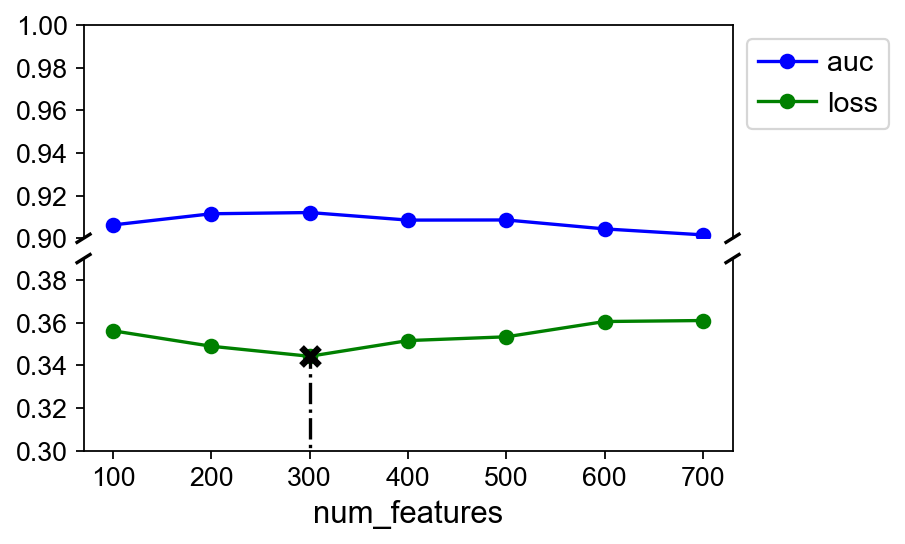

In [14]:
params_2 = {
    "num_features": range(100, 800, 100)
}
nnmodel_2 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv2 = hop.grid_search(nnmodel_2, params_2, train_feature, train_label, figname = dirname + "/NN_num_features")

In [15]:
cv2.best_params_

{'num_features': 300}

mean_score_time                 0.059614
mean_test_loss                 -0.341229
std_test_loss                   0.009905
mean_test_auc                   0.914819
std_test_auc                    0.004707
rank_test_loss                         1
rank_test_auc                          1
params             {'num_features': 250}
Name: 4, dtype: object


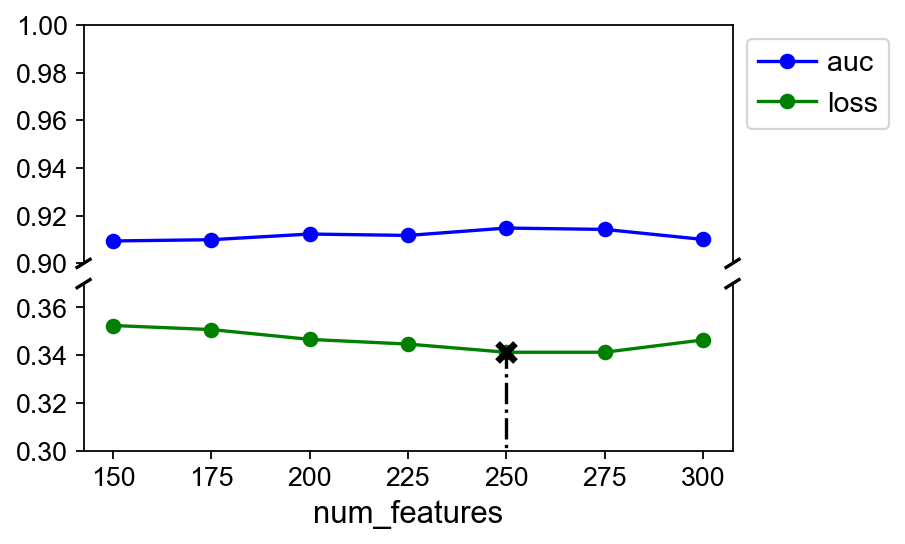

In [16]:
params_3 = {
    "num_features": [150, 175, 200, 225, 250, 275, 300]
}
nnmodel_3 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"],
    batch_size = cv1.best_params_["batch_size"]
)
cv3 = hop.grid_search(nnmodel_3, params_3, train_feature, train_label, figname = dirname + "/NN_num_features")

In [17]:
cv3.best_params_

{'num_features': 250}

优化 batch_size：网格搜索

mean_score_time              0.065226
mean_test_loss              -0.339872
std_test_loss                0.012259
mean_test_auc                0.912245
std_test_auc                 0.006011
rank_test_loss                      1
rank_test_auc                       4
params             {'batch_size': 16}
Name: 1, dtype: object


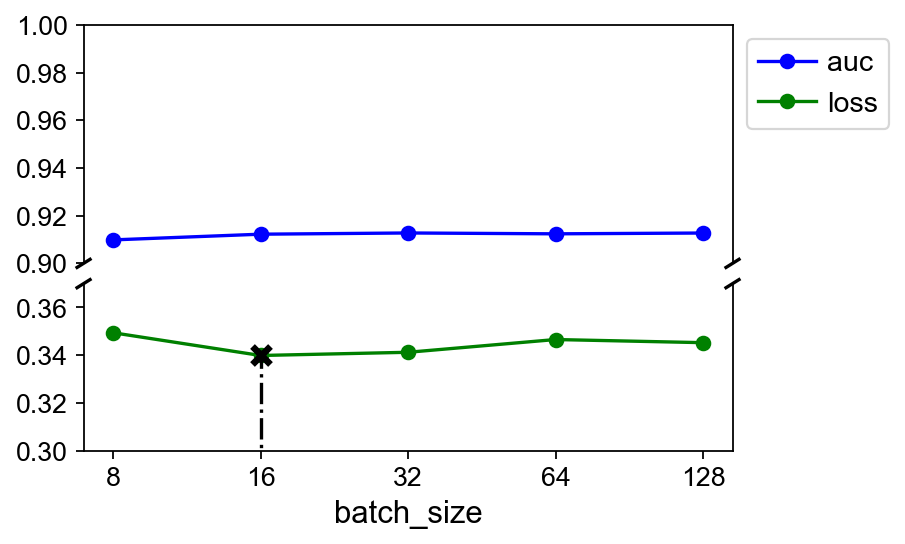

In [18]:
params_4 = {
    "batch_size": [8, 16, 32, 64, 128]
}
nnmodel_4 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv3.best_params_["num_features"], 
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"], 
    dropout_rate = cv1.best_params_["dropout_rate"]
)
cv4 = hop.grid_search(nnmodel_4, params_4, train_feature, train_label, figname = dirname + "/NN_batch_size")

In [19]:
cv4.best_params_

{'batch_size': 16}

优化 dropout_rate：网格搜索

mean_score_time                 0.069975
mean_test_loss                 -0.340086
std_test_loss                   0.008514
mean_test_auc                   0.913977
std_test_auc                    0.004741
rank_test_loss                         1
rank_test_auc                          2
params             {'dropout_rate': 0.1}
Name: 1, dtype: object


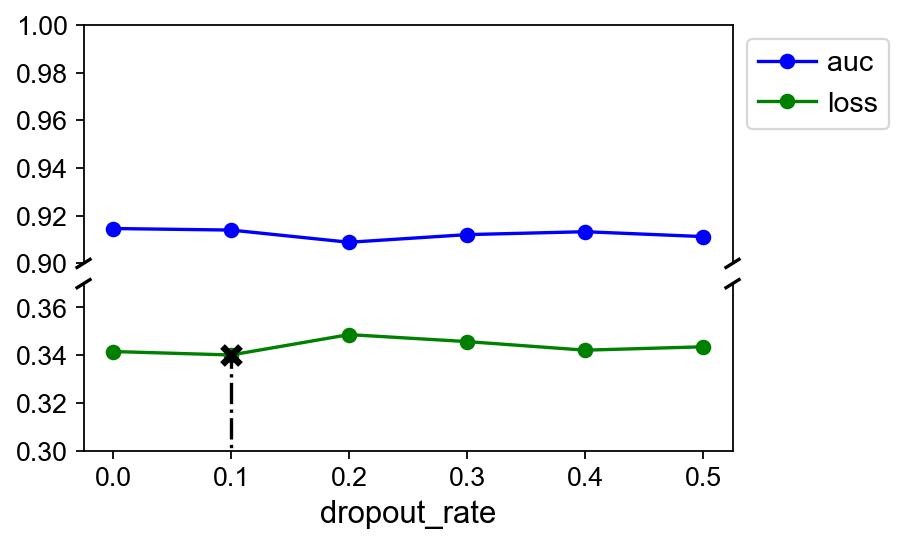

In [20]:
params_5 = {
    "dropout_rate": np.arange(0.0, 0.6, 0.1).round(1)
}
nnmodel_5 = nn_model.NeuralNetworkClassifier(
    verbose = False, 
    num_features = cv3.best_params_["num_features"], 
    batch_size = cv4.best_params_["batch_size"],
    hidden_layer_sizes = cv1.best_params_["hidden_layer_sizes"]
)
cv5 = hop.grid_search(nnmodel_5, params_5, train_feature, train_label, figname = dirname + "/NN_dropout_rate")

In [21]:
cv5.best_params_

{'dropout_rate': 0.1}

### 构建模型

第0轮，训练损失：0.4985
第0轮，验证损失：0.4468
Validation loss decreased (inf --> 0.446759).  Saving model ...
第1轮，训练损失：0.4373
第1轮，验证损失：0.4207
Validation loss decreased (0.446759 --> 0.420724).  Saving model ...
第2轮，训练损失：0.3989
第2轮，验证损失：0.3970
Validation loss decreased (0.420724 --> 0.396957).  Saving model ...
第3轮，训练损失：0.3611
第3轮，验证损失：0.3727
Validation loss decreased (0.396957 --> 0.372658).  Saving model ...
第4轮，训练损失：0.3286
第4轮，验证损失：0.3575
Validation loss decreased (0.372658 --> 0.357524).  Saving model ...
第5轮，训练损失：0.3029
第5轮，验证损失：0.3647
EarlyStopping counter: 1 out of 7
第6轮，训练损失：0.2820
第6轮，验证损失：0.3643
EarlyStopping counter: 2 out of 7
第7轮，训练损失：0.2621
第7轮，验证损失：0.3568
Validation loss decreased (0.357524 --> 0.356849).  Saving model ...
第8轮，训练损失：0.2486
第8轮，验证损失：0.3502
Validation loss decreased (0.356849 --> 0.350224).  Saving model ...
第9轮，训练损失：0.2323
第9轮，验证损失：0.3665
EarlyStopping counter: 1 out of 7
第10轮，训练损失：0.2265
第10轮，验证损失：0.3511
EarlyStopping counter: 2 out of 7
第11轮，训练损失：0.2136
第11轮，验证损失：0.381

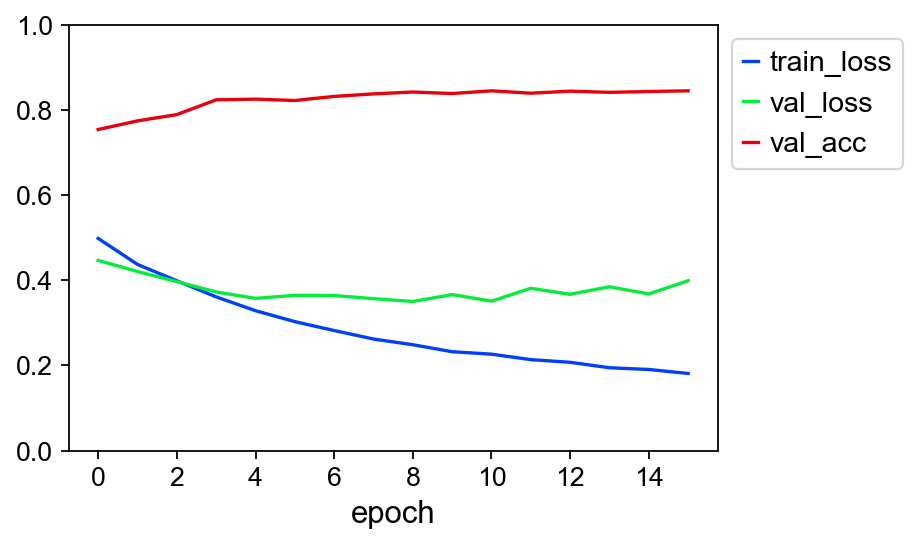

{'Accuracy': 0.8499641062455133,
 'Precision': 0.732484076433121,
 'Recall': 0.8665231431646933,
 'MCC': 0.6831488640778063,
 'F_Score': 0.7938856015779093,
 'AUC': 0.9222544319257481,
 'Average Precision': 0.8019429807961161,
 'confusion_matrix': array([[1563,  294],
        [ 124,  805]], dtype=int64)}

In [16]:
nnmodel = nn_model.NeuralNetworkClassifier(
    num_features = 250, 
    batch_size = 16,
    hidden_layer_sizes = (400, 50),
    dropout_rate = 0.5
)
nnmodel.fit(train_feature, train_label)
pred = nnmodel.predict(test_feature)
predprob = nnmodel.predict_proba(test_feature)
eval.evaluate(test_label, pred, predprob, verbose = False)